## Version 1.01 

Idk how to do version control so the numbers will be mostly arbitrary.

This version has graphs for the first set of values in feedback.txt file from Charley

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Peterlin function
def peterlin(sigma, L2=31490.0):
    tr_sigma = np.trace(sigma)
    return (L2 - 3.0) / (L2 - tr_sigma)

# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad):
    return - (sigma @ grad + grad.T @ sigma)

# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y):
    sigma_u = y[:9].reshape((3, 3))
    sigma_b = y[9:18].reshape((3, 3))
    p = y[18]
    grad = grad_v(t)
    
    # Compute Peterlin factors
    fP_u = peterlin(sigma_u)
    fP_b = peterlin(sigma_b)

    # Eqn for sigma_u
    dsigma_u_dt = (1-p)* nkT * (grad + grad.T) \
                   - ((1 + k_plus * tau_u) * fP_u * sigma_u \
                   + k_minus * tau_u * fP_b * sigma_b \
                   - tau_u * upper_convected(t, sigma_u, grad))/tau_u

    # Eqn for sigma_b
    dsigma_b_dt = p* nkT * (grad + grad.T) \
                   - ((1 + k_minus * tau_b) * fP_b * sigma_b \
                   + k_plus * tau_b * fP_u * sigma_u \
                   - tau_b * upper_convected(t, sigma_b, grad))/tau_b
                   
    dp_dt = k_plus * (1-p ) - k_minus * p

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten(), [dp_dt]])

### Getting data from parameters

In [6]:
# Define parameters
alpha = 1.1 #Not sure why alpha is 1.1, I think it should be 1.71 based off equation 21 in pdf
tau_u = 0.0378
tau_b = 2.4487
k_plus = 0.62226 #Binding rate of sorts 
k_minus = 1.3130 #Unbinding rate of sorts
nkT = 16877.04 #In Pascals

phi = (tau_b/tau_u)**0.5 #Ratio between conformational relaxation times, see section C in Sticky_Dumbbell_4 pdf
p = (k_plus*phi)/((k_plus*phi)+(k_minus*(phi)**-1)) #Fractions of closed stickers, see ^


StrainRate=[0.001, 0.01, 0.1, 1.0, 2.0, 3.0]

# Velocity gradient tensor (example: simple shear)
def grad_v(t):
    return 0.5*np.array([[2*StrainRate[i], 0.0, 0.0],
                         [0.0, -StrainRate[i], 0.0],
                         [0.0, 0.0, -StrainRate[i]]])

# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
p0 = 1.0/( 1.0 + k_plus/k_minus ) # fraction of closed stickers
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten(), [p0]])


# Time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 5000000)

#Lists to hold outputted data
sigma_u_list = []
sigma_b_list = []
p_list = []
time_list = []

for i in range(len(StrainRate)):
    # Solve
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')
    
    #----------------------------------------
    #Code below to extract only a set amount of solutions to make the graphs generate faster!
    # Extract solutions
    # Number of samples you want
    n_samples = 200  # for example

    # Get time array from the solution
    t = sol.t
    y=sol.y
    mask = t > 0
    t = t[mask]
    y = y[:, mask]

    # Create log-spaced sampling points between min and max of t
    t_log = np.logspace(np.log10(t[0]), np.log10(t[-1]), n_samples)

    # Interpolate solution at those points
    from scipy.interpolate import interp1d

    interp_func = interp1d(t, y, kind='linear', axis=1, fill_value="extrapolate")
    y_log = interp_func(t_log)
    
    # Recreate the sigma_u and sigma_b arrays
    sigma_u_sol = y_log[:9, :].T.reshape(-1, 3, 3)
    sigma_b_sol = y_log[9:18, :].T.reshape(-1, 3, 3)
    p_sol = sol.y[18:, :] # extract p solution
    #Append to lists to keep outside the loop
    sigma_u_list.append(sigma_u_sol)
    sigma_b_list.append(sigma_b_sol)
    p_list.append(p_sol)
    #----------------------------------------
    #sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
    #sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)

    # Example: print sigma_u at final time
    print(f"Sigma_u at t=10 for strain_rate={StrainRate[i]}:")
    print(sigma_u_sol[-1])

    # ---- Plotting ----
    t = sol.t
    t=t_log
    time_list.append(t)

Sigma_u at t=10 for strain_rate=0.001:
[[ 0.55028218  0.          0.        ]
 [ 0.         -0.27458548  0.        ]
 [ 0.          0.         -0.27458548]]
Sigma_u at t=10 for strain_rate=0.01:
[[ 5.5250028   0.          0.        ]
 [ 0.         -2.74062487  0.        ]
 [ 0.          0.         -2.74062487]]
Sigma_u at t=10 for strain_rate=0.1:
[[ 57.55551502   0.           0.        ]
 [  0.         -26.64150635   0.        ]
 [  0.           0.         -26.64150635]]
Sigma_u at t=10 for strain_rate=1.0:
[[754.02306815   0.           0.        ]
 [  0.         336.97809073   0.        ]
 [  0.           0.         336.97809073]]
Sigma_u at t=10 for strain_rate=2.0:
[[1418.15590708    0.            0.        ]
 [   0.          -85.06627533    0.        ]
 [   0.            0.          -85.06627533]]
Sigma_u at t=10 for strain_rate=3.0:
[[2025.36227692    0.            0.        ]
 [   0.         -549.4102192     0.        ]
 [   0.            0.         -549.4102192 ]]


### Plotting Graphs

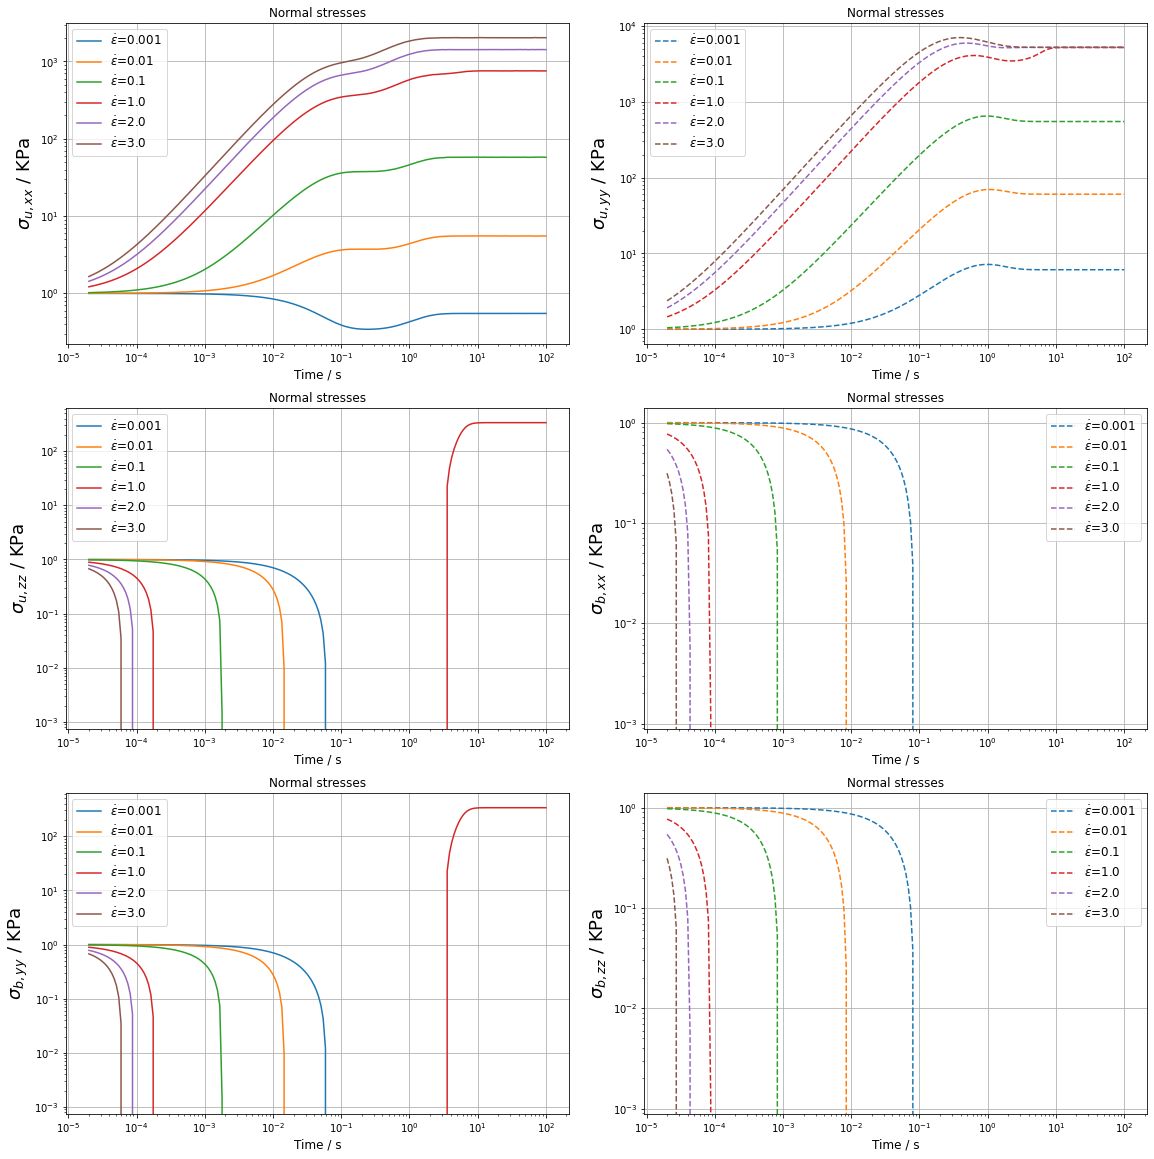

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.tight_layout(pad=2.0) 
axs = axs.flatten() #Making it a 1D array, in number order
for i in range(len(StrainRate)):
    sigma_u_sol = sigma_u_list[i]
    sigma_b_sol = sigma_b_list[i]
    axs[0].plot(t, sigma_u_sol[:, 0, 0], label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")
    axs[2].plot(t, sigma_u_sol[:, 1, 1], label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")
    axs[4].plot(t, sigma_u_sol[:, 2, 2], label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")
    axs[1].plot(t, sigma_b_sol[:, 0, 0], '--', label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")
    axs[3].plot(t, sigma_b_sol[:, 1, 1], '--', label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")
    axs[5].plot(t, sigma_b_sol[:, 2, 2], '--', label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")

#Making a list which holds the labels for the y-axis
y_axis_labels = [r"$\sigma_{u,xx}$", r"$\sigma_{u,yy}$", r"$\sigma_{u,zz}$",
                 r"$\sigma_{b,xx}$", r"$\sigma_{b,yy}$", r"$\sigma_{b,zz}$"]
for i in range(len(StrainRate)):
    axs[i].set_title("Normal stresses")
    axs[i].set_xlabel("Time / s", fontsize=12)
    axs[i].set_ylabel(f"{y_axis_labels[i]} / KPa", fontsize=18)
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].legend(fontsize=12)
    axs[i].grid(True)
    
fig.subplots_adjust(wspace=0.15, hspace=0.2)
fig.savefig("normal_stresses_graphs_k=0.3.png", dpi=300, bbox_inches="tight")

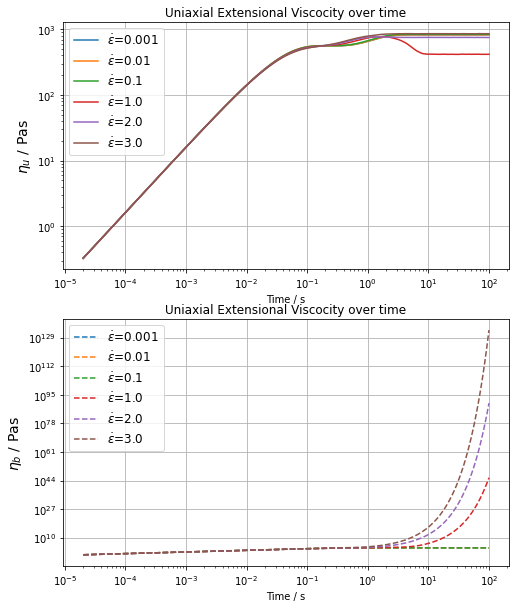

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] #List of default matplotlib colors
axs = axs.flatten() #Making it a 1D array, in number order
for i in range(len(StrainRate)):
    sigma_u_sol = sigma_u_list[i]
    sigma_b_sol = sigma_b_list[i]
    uniaxial_ext_visc_u = (sigma_u_sol[:, 0, 0] - sigma_u_sol[:, 1, 1])/StrainRate[i]
    uniaxial_ext_visc_b = (sigma_b_sol[:, 0, 0] - sigma_b_sol[:, 1, 1])/StrainRate[i]

    # --- New plot: Stress vs Strain ---
    axs[0].plot(t, uniaxial_ext_visc_u, label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")#, c=colors[5])
    axs[1].plot(t, uniaxial_ext_visc_b, '--', label=fr"$\dot{{\epsilon}}$={StrainRate[i]}")#, c=colors[5])


axs[0].set_xlabel("Time / s")
axs[0].set_ylabel(r"$\eta_{u}$ / Pas", fontsize=14)
axs[0].set_title("Uniaxial Extensional Viscocity over time")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].legend(fontsize=12)
axs[0].grid(True)

axs[1].set_xlabel("Time / s")
axs[1].set_ylabel(r"$\eta_{b}$ / Pas", fontsize=14)
axs[1].set_title("Uniaxial Extensional Viscocity over time")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].legend(fontsize=12)
axs[1].grid(True)


fig.savefig("extens_visc_graphs_k=0.3.png", dpi=300, bbox_inches="tight")